# Exploitation

This section implements pure exploitation process where the next infill point is obtained by minimizing the surrogate model.  Below code imports required packages, defines branin function, and creates plotting data:

In [74]:
# Imports
import numpy as np
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)

    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

# Bounds
lb = np.array([-5, 10])
ub = np.array([0, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array([lb, ub]))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)

Differential evolution (DE) from `pymoo` is used for minimizing the surrogate model. Below code defines problem class and initializes DE. Note that the problem class is defined to use the surrogate model prediction instead of the actual function.

In [68]:
# Problem class
class Surrogate(Problem):

    def __init__(self, sm):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = self.sm.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=30, CR=0.8, dither="vector")

Below block of code defines the training data (based on previous section) and performs the exploitation process. The maximum number of iterations is set to 15 and a convergence criterion is defined based on the change in 

In [64]:
sampler = LHS(xlimits=np.array([lb, ub]), criterion='ese')

# Training data
num_train = 10
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)

# Variables
itr = 0
max_itr = 15
tol = 1e-3
error = 1
criteria = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < error:
    
    print("Iteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    print(sm.optimal_theta)

    # Find the minimum of surrogate model
    result = minimize(Surrogate(sm), algorithm, seed=1, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))
    
    # Comuting error
    error = np.abs(result.F - y_infill)/np.abs(result.F)
    criteria.append(error)

    print("Error: {}".format(error))

    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.X))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

Iteration 1
[0.6639463  0.13025924]
Error: [2.1779993]
f*: [5.03523926]
x*: [-2.20199347 13.55317868]
Iteration 2
[0.64258746 0.28068428]
Error: [1.14667882]
f*: [1.71497475]
x*: [-1.76953151 10.78872486]
Iteration 3
[0.38065165 0.49067782]
Error: [0.42734941]
f*: [-15.27901251]
x*: [-3.77367636 12.68966168]
Iteration 4
[0.33962511 0.34873465]
Error: [0.75084926]
f*: [-4.3428244]
x*: [-4.7072263  13.31404061]
Iteration 5
[1.09451527 0.20515828]
Error: [0.03025666]
f*: [-16.31847182]
x*: [-3.56376933 12.80328924]
Iteration 6
[1.10031104 0.14874716]
Error: [0.01041208]
f*: [-16.63899482]
x*: [-3.67342702 13.52647745]
Iteration 7
[1.06712434 0.13220272]
Error: [0.00180436]
f*: [-16.6230107]
x*: [-3.63772887 13.39911196]
Iteration 8
[0.93723469 0.09815405]
Error: [0.00014521]
f*: [-16.64023045]
x*: [-3.70376515 13.61269344]


Text(0.5, 1.0, 'Branin function')

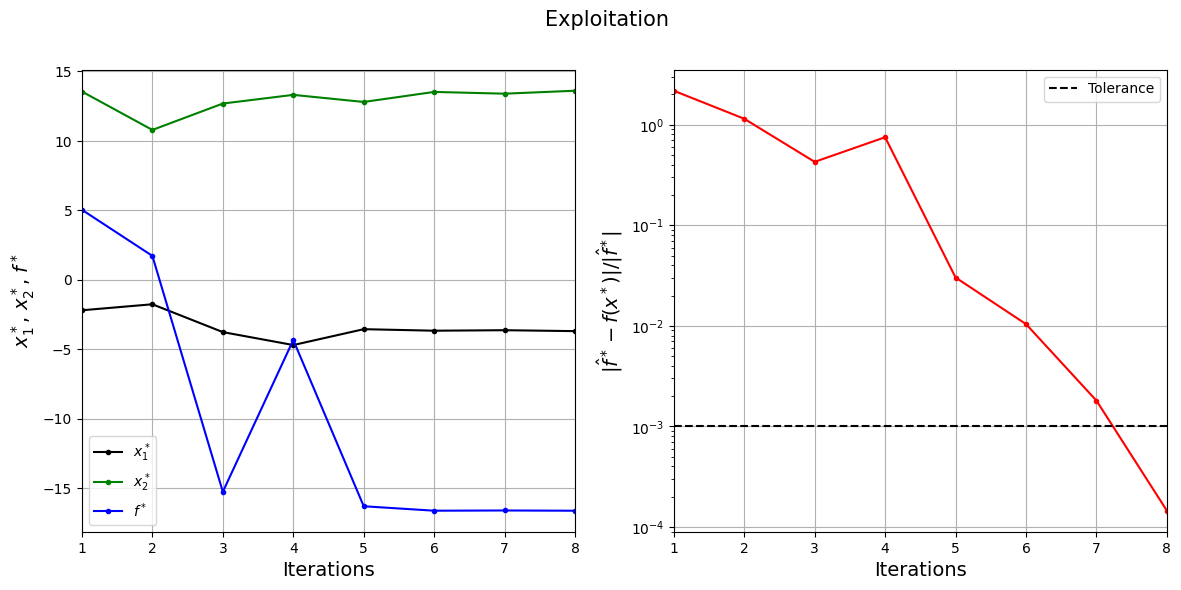

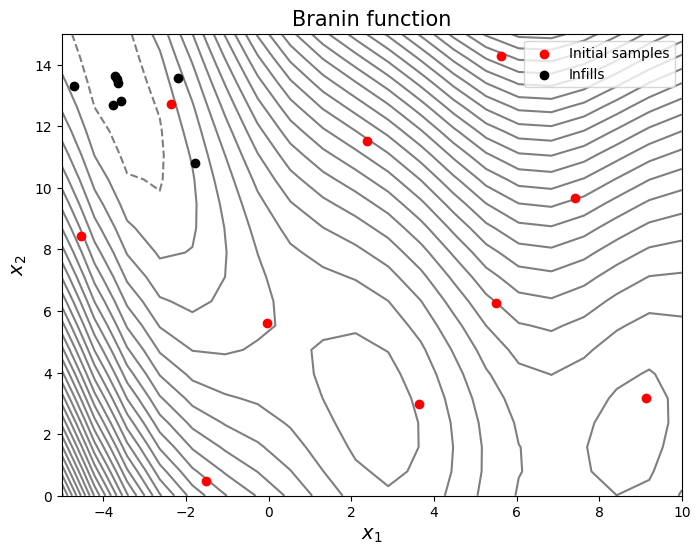

In [88]:
####################################### Plotting convergence history

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,0], c="black", label='$x_1^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,1], c="green", label='$x_2^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, ytrain[num_train:], c="blue", label='$f^*$', marker=".")
ax[0].set_xlabel("Iterations", fontsize=14)
ax[0].set_ylabel("$x_1^*$, $x_2^*$, $f^*$", fontsize=14)
ax[0].legend()
ax[0].set_xlim(left=1, right=itr)
ax[0].grid()

ax[1].plot(np.arange(itr) + 1, criteria, c="red", marker=".")
ax[1].plot(np.arange(itr) + 1, [tol]*itr, c="black", linestyle="--", label="Tolerance")
ax[1].set_xlabel("Iterations", fontsize=14)
ax[1].set_ylabel("$| \hat{f}^* - f(x^*) | / | \hat{f}^* |$", fontsize=14)
ax[1].set_xlim(left=1, right=itr)
ax[1].grid()
ax[1].legend()
ax[1].set_yscale("log")

fig.suptitle("Exploitation".format(itr), fontsize=15)

####################################### Plotting initial samples and infills

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)

fig, ax = plt.subplots(figsize=(8,6))
cm = ax.contour(X, Y, Z, levels=30, colors='k', alpha=0.5, zorder=-10)
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.legend()

ax.set_title("Branin function", fontsize=15)